In [4]:
# ======================================
# 🚗 ETL DATA UJI KENDARAAN 2025 FINAL
# Hasil akhir: file .sql siap import ke MySQL / phpMyAdmin
# ======================================

import pandas as pd
import numpy as np

# 1️⃣ Upload file Excel
from google.colab import files
uploaded = files.upload()

# Ambil nama file upload
file_name = list(uploaded.keys())[0]
print(f"✅ File berhasil diupload: {file_name}")

# 2️⃣ Baca semua sheet dalam file Excel
xls = pd.ExcelFile(file_name)
print("📑 Sheet yang tersedia:", xls.sheet_names)

# 3️⃣ Baca sheet utama (laporan hasil uji)
df = pd.read_excel(xls, sheet_name='Laporan_HasilUji_tahunan_2025')
print("✅ Data utama:", df.shape, "baris")

# Normalisasi nama kolom
df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
df.columns = df.columns.str.lower()

# 4️⃣ Baca sheet numpang & uji ulang (auto skip header kalau gak di baris 1)
def read_sheet_smart(xls, name):
    for skip in [0, 1, 2, 3]:
        try:
            df_tmp = pd.read_excel(xls, sheet_name=name, skiprows=skip)
            if df_tmp.shape[1] > 1 and df_tmp.shape[0] > 0:
                return df_tmp
        except:
            pass
    return pd.DataFrame()

df_numpang = read_sheet_smart(xls, 'Daftar_Kendaraan_Numpang_Uji')
df_ujiulang = read_sheet_smart(xls, 'Daftar_Kendaraan_Uji_Ulang')

print("✅ Data Numpang Uji:", df_numpang.shape)
print("✅ Data Uji Ulang:", df_ujiulang.shape)

# Gabungkan keduanya
df_numpang_uji = pd.concat([df_numpang, df_ujiulang], ignore_index=True)

# Normalisasi kolom (kalau ada)
if not df_numpang_uji.empty:
    df_numpang_uji.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df_numpang_uji.columns]
    df_numpang_uji.columns = df_numpang_uji.columns.str.lower()

# 5️⃣ Tambahkan kolom uji_ulang ke data utama
df["uji_ulang"] = df["no_uji"].isin(df_numpang_uji.get("no_uji", [])).map({True: "Ya", False: "Tidak"})

# 6️⃣ Pastikan kolom tanggal dalam format datetime
df["tanggal_uji"] = pd.to_datetime(df["tanggal_uji"], errors="coerce")

# 7️⃣ Hitung KPI
total_kendaraan = len(df)
lulus = len(df[df["hasil_uji"].str.lower() == "lulus"])
tidak_lulus = len(df[df["hasil_uji"].str.lower() == "tidak lulus"])
uji_ulang = len(df[df["uji_ulang"] == "Ya"])

pass_rate = round((lulus / total_kendaraan) * 100, 2)
fail_rate = round((tidak_lulus / total_kendaraan) * 100, 2)
persen_uji_ulang = round((uji_ulang / total_kendaraan) * 100, 2)

kpi_summary = pd.DataFrame({
    "KPI": [
        "Total Kendaraan Diuji",
        "Tingkat Kelulusan (Pass Rate)",
        "Tingkat Ketidaklulusan (Fail Rate)",
        "Persentase Kendaraan Uji Ulang"
    ],
    "Nilai": [total_kendaraan, pass_rate, fail_rate, persen_uji_ulang],
    "Satuan": ["Unit", "%", "%", "%"]
})

# 8️⃣ Distribusi lulus / tidak lulus per bulan
df["bulan"] = df["tanggal_uji"].dt.month_name()
df["tahun"] = df["tanggal_uji"].dt.year

distribusi = df.groupby(["tahun", "bulan", "hasil_uji"]).size().reset_index(name="jumlah_kendaraan")

# 9️⃣ Growth rate uji ulang per bulan
uji_ulang_bulanan = df[df["uji_ulang"] == "Ya"].groupby(["tahun", "bulan"]).size().reset_index(name="jumlah_uji_ulang")
uji_ulang_bulanan["growth_rate_%"] = uji_ulang_bulanan["jumlah_uji_ulang"].pct_change() * 100

# 10️⃣ Simpan semua tabel ke file .sql
tables = {
    "data_hasil_uji": df,
    "distribusi_lulus_tidak_lulus": distribusi,
    "growth_rate_uji_ulang": uji_ulang_bulanan,
    "kpi_summary": kpi_summary
}

sql_output = ""
for name, data in tables.items():
    sql_output += f"-- Table: {name}\n"
    sql_output += f"DROP TABLE IF EXISTS `{name}`;\n"
    cols = ", ".join([f"`{c}` TEXT" for c in data.columns])
    sql_output += f"CREATE TABLE `{name}` ({cols});\n"
    for _, row in data.iterrows():
        values = ", ".join([f"'{str(v).replace("'", "''")}'" if pd.notnull(v) else "NULL" for v in row])
        sql_output += f"INSERT INTO `{name}` VALUES ({values});\n"
    sql_output += "\n"

# 11️⃣ Simpan ke file .sql
sql_file = "output_mysql_fix_merge_2025.sql"
with open(sql_file, "w", encoding="utf-8") as f:
    f.write(sql_output)

print(f"✅ File '{sql_file}' berhasil dibuat dan siap diimport ke phpMyAdmin 🎯")

# 12️⃣ Otomatis download file SQL
files.download(sql_file)

# 13️⃣ Tampilkan hasil KPI Summary
print("\n📊 KPI Summary:")
print(kpi_summary)

Saving DATA HASIL UJI 2025.xlsx to DATA HASIL UJI 2025 (1).xlsx
✅ File berhasil diupload: DATA HASIL UJI 2025 (1).xlsx
📑 Sheet yang tersedia: ['Laporan_HasilUji_tahunan_2025', 'Daftar_Kendaraan_Uji_Ulang', 'Daftar_Kendaraan_Numpang_Uji']
✅ Data utama: (46567, 8) baris
✅ Data Numpang Uji: (293, 8)
✅ Data Uji Ulang: (1229, 8)
✅ File 'output_mysql_fix_merge_2025.sql' berhasil dibuat dan siap diimport ke phpMyAdmin 🎯


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 KPI Summary:
                                  KPI     Nilai Satuan
0               Total Kendaraan Diuji  46567.00   Unit
1       Tingkat Kelulusan (Pass Rate)      0.00      %
2  Tingkat Ketidaklulusan (Fail Rate)      0.00      %
3      Persentase Kendaraan Uji Ulang      2.41      %


In [6]:
# ============================================
# 🚗 ETL AUTOMATION: Data Numpang Uji (Full Table)
# Output: data_numpang_uji.sql (for MySQL)
# ============================================

!pip install pandas openpyxl sqlalchemy

import pandas as pd
from google.colab import files

print("📂 Silakan upload file 'Daftar_Kendaraan_Numpang_Uji.xlsx'")
uploaded = files.upload()

# --- Baca data utama ---
file_name = "Daftar_Kendaraan_Numpang_Uji.xlsx"
df = pd.read_excel(file_name)

print("✅ Data berhasil dibaca. Preview 5 baris awal:")
display(df.head())

# --- Pembersihan dasar ---
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df = df.drop_duplicates()
df = df.dropna(how="all")

# --- Tambahkan kolom bulan & tahun jika ada tanggal ---
tanggal_cols = [c for c in df.columns if "tanggal" in c]
if len(tanggal_cols) > 0:
    col_tanggal = tanggal_cols[0]
    df[col_tanggal] = pd.to_datetime(df[col_tanggal], errors="coerce")
    df["bulan"] = df[col_tanggal].dt.month
    df["tahun"] = df[col_tanggal].dt.year
else:
    df["bulan"] = None
    df["tahun"] = None
    print("⚠️ Kolom tanggal tidak ditemukan — kolom bulan & tahun diisi kosong.")

# --- Preview hasil akhir ---
print("\n📊 Data Bersih Siap MySQL (sample):")
display(df.head())

# --- Simpan ke file SQL ---
sql_filename = "data_numpang_uji.sql"

# Buat definisi kolom otomatis
create_cols = []
for col, dtype in zip(df.columns, df.dtypes):
    if "int" in str(dtype):
        sql_type = "INT"
    elif "float" in str(dtype):
        sql_type = "FLOAT"
    elif "datetime" in str(dtype):
        sql_type = "DATETIME"
    else:
        sql_type = "VARCHAR(255)"
    create_cols.append(f"  {col} {sql_type}")
create_table = "CREATE TABLE IF NOT EXISTS data_numpang_uji (\n" + ",\n".join(create_cols) + "\n);\n\n"

# Simpan data ke file SQL
with open(sql_filename, "w", encoding="utf-8") as f:
    f.write("-- ============================================\n")
    f.write("-- SQL Export: Data Numpang Uji (Cleaned)\n")
    f.write("-- ============================================\n\n")
    f.write(create_table)

    for _, row in df.iterrows():
        values = []
        for val in row:
            if pd.isna(val):
                values.append("NULL")
            elif isinstance(val, str):
                val = val.replace("'", "''")
                values.append(f"'{val}'")
            elif isinstance(val, pd.Timestamp):
                values.append(f"'{val.strftime('%Y-%m-%d')}'")
            else:
                values.append(str(val))
        f.write(f"INSERT INTO data_numpang_uji VALUES ({', '.join(values)});\n")

# --- Otomatis download file SQL ---
files.download(sql_filename)

print("\n✅ Proses ETL selesai! File 'data_numpang_uji.sql' siap diimport ke MySQL 🚀")

📂 Silakan upload file 'Daftar_Kendaraan_Numpang_Uji.xlsx'


Saving Daftar_Kendaraan_Numpang_Uji.xlsx to Daftar_Kendaraan_Numpang_Uji.xlsx
✅ Data berhasil dibaca. Preview 5 baris awal:


,No_Uji,No_Pol,id_Nama,id_Chasis,Kode_Mesin_Kendaraan,Hasil_Uji,Tanggal_Uji
0,JKT1319489,B9635BCK,PT MANDALA DHARMA KRIDA,MHMFE74P4P5DK066845,4D34TJ33360,L,2025-01-03
1,JKT2008659,B9989TCN,PT CSM CORPORATAMA,MHKB3BA1JLK065909,K3MH66846,L,2025-01-03
2,JKT806903,B9671BAD,TINA NORMINA,MHYESL415BJ208962,G15AID822804,L,2025-01-06
3,JKT2303467,B9186BAY,SUWARYO,MHYHDC61TNJ244073,K15BT1427686,L,2025-01-06
4,JKT735308,B9745NM,PT GRYA INTI JAYA,MHYESL4159J136894,G15AID743930,L,2025-01-06



📊 Data Bersih Siap MySQL (sample):


,no_uji,no_pol,id_nama,id_chasis,kode_mesin_kendaraan,hasil_uji,tanggal_uji,bulan,tahun
0,JKT1319489,B9635BCK,PT MANDALA DHARMA KRIDA,MHMFE74P4P5DK066845,4D34TJ33360,L,2025-01-03,1,2025
1,JKT2008659,B9989TCN,PT CSM CORPORATAMA,MHKB3BA1JLK065909,K3MH66846,L,2025-01-03,1,2025
2,JKT806903,B9671BAD,TINA NORMINA,MHYESL415BJ208962,G15AID822804,L,2025-01-06,1,2025
3,JKT2303467,B9186BAY,SUWARYO,MHYHDC61TNJ244073,K15BT1427686,L,2025-01-06,1,2025
4,JKT735308,B9745NM,PT GRYA INTI JAYA,MHYESL4159J136894,G15AID743930,L,2025-01-06,1,2025


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Proses ETL selesai! File 'data_numpang_uji.sql' siap diimport ke MySQL 🚀


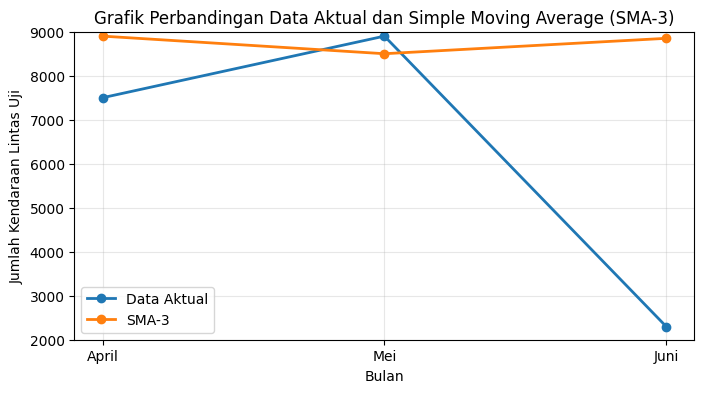

In [7]:
import matplotlib.pyplot as plt

# Data (disesuaikan agar bentuk grafik mirip gambar)
bulan = ["April", "Mei", "Juni"]

data_aktual = [7500, 8900, 2300]   # garis biru
sma_3       = [8900, 8500, 8850]   # garis oranye (SMA-3 seperti di gambar)

plt.figure(figsize=(8, 4))

# Plot Data Aktual
plt.plot(bulan, data_aktual, marker="o", linewidth=2, label="Data Aktual")

# Plot SMA-3
plt.plot(bulan, sma_3, marker="o", linewidth=2, label="SMA-3")

# Judul dan label sumbu sesuai gambar
plt.title("Grafik Perbandingan Data Aktual dan Simple Moving Average (SMA-3)")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Kendaraan Lintas Uji")

# Biar tampilannya mirip
plt.ylim(2000, 9000)   # rentang kira-kira seperti gambar
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()


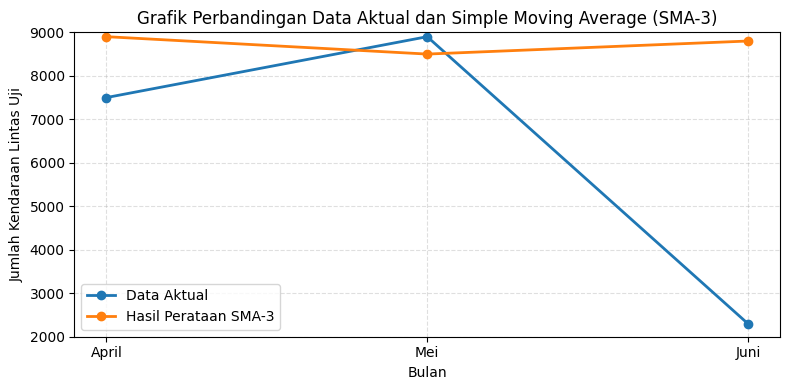

In [8]:
import matplotlib.pyplot as plt

# Data sesuai grafik
bulan = ["April", "Mei", "Juni"]

data_aktual = [7500, 8900, 2300]
sma_3 = [8900, 8500, 8800]

plt.figure(figsize=(8, 4))

# Garis Data Aktual
plt.plot(
    bulan,
    data_aktual,
    marker='o',
    color='tab:blue',
    linewidth=2,
    label='Data Aktual'
)

# Garis Hasil Perataan SMA-3
plt.plot(
    bulan,
    sma_3,
    marker='o',
    color='tab:orange',
    linewidth=2,
    label='Hasil Perataan SMA-3'
)

# Judul dan label
plt.title("Grafik Perbandingan Data Aktual dan Simple Moving Average (SMA-3)")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Kendaraan Lintas Uji")

# Tampilan sumbu & grid
plt.ylim(2000, 9000)
plt.grid(True, linestyle='--', alpha=0.4)

# Legenda
plt.legend()

plt.tight_layout()
plt.show()


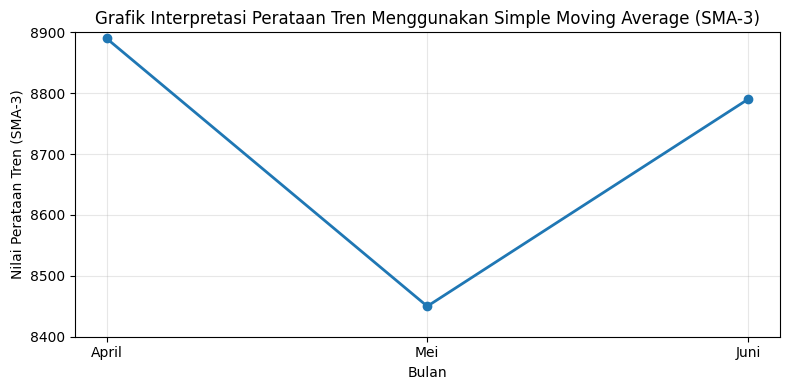

In [9]:
import matplotlib.pyplot as plt

# Data sesuai grafik interpretasi SMA-3
bulan = ["April", "Mei", "Juni"]
nilai_sma_tren = [8890, 8450, 8790]

plt.figure(figsize=(8, 4))

# Plot garis SMA-3
plt.plot(
    bulan,
    nilai_sma_tren,
    marker='o',
    linewidth=2
)

# Judul dan label
plt.title("Grafik Interpretasi Perataan Tren Menggunakan Simple Moving Average (SMA-3)")
plt.xlabel("Bulan")
plt.ylabel("Nilai Perataan Tren (SMA-3)")

# Pengaturan sumbu agar mirip gambar
plt.ylim(8400, 8900)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
